# NLP for Fake News Classification

A dataset from [Real or Fake](https://www.kaggle.com/rchitic17/real-or-fake) is provided containing different news articles.

We want to build a  model that can classify if a given article is considered fake or not. We will use a subset of the data for training and the remaining for testing our model.

## Outline

We separate the project in 3 steps:

**Data Loading and Processing:** Load the data and analyze it to obtain an accurate picture of it, its features, its values (and whether they are incomplete or wrong), its data types among others. We also do the required processing.

**Feature Engineering / Modeling:** Once we have the data, we create some features and then the modeling stage begins, we set multiple baselines making use of different models, we will hopefully produce a model that fits our expectations of performance. Once we have that model, a process of tuning it to the training data would be performed.

**Results and Conclusions:** Finally, with our tuned model, we  predict against the test set, and finally, outline our conclusions.

In [4]:
import re
import eli5
import spacy
import nltk as nl
import pandas as pd
from sklearn.base import clone
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from nltk.corpus import stopwords
from ml_helper.helper import Helper
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scikitplot.metrics import plot_confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score as metric_scorer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
nl.download('stopwords')
%matplotlib inline

### Setting Key Values

The following values are used throught the code, this cell gives a central source where they can be managed.

In [2]:
KEYS = {
    "SEED": 1,
    "DATA_PATH": "../input/fake_or_real_news.csv",
    "TARGET": "label",
    "METRIC": "accuracy",
    "TIMESERIES": False,
    "SPLITS": 3,
    "ESTIMATORS": 150,
    "ITERATIONS": 500,
}

hp = Helper(KEYS)

## Data Loading and Processing

Here we load the necessary data, splitting 80% for training and the remaining 20% for testing. We also review its types and print its first rows.

In [3]:
df = pd.read_csv(KEYS["DATA_PATH"], header=0, names=["id", "title", "text", "label"])
train, test = train_test_split(df, test_size=0.20, random_state=KEYS["SEED"])

### Data Types

In [4]:
train.dtypes

id        int64
title    object
text     object
label    object
dtype: object

### First Rows of the Data

In [5]:
train.head()

,id,title,text,label
4541,10536,Statistical Propaganda: How many Syrians has U...,"October 31, 2016 - Fort Russ - Aleksandr Khro...",FAKE
2490,8274,'Russia has no intention of attacking anyone -...,"October 28, 2016 112 While the Western press c...",FAKE
4928,3504,"Trump, Clinton trade blows on terror and guns ...",While investigators try to piece together what...,REAL
5627,1844,Clinton clearing primary field for potential 2...,Hillary Clinton appears to have scared away mu...,REAL
757,2706,What Brian Williams’s Chopper Whopper Says Abo...,Embarrassing and infuriating: the NBC anchor’s...,REAL


### Missing Data

We check if there is any missing data.

In [6]:
hp.missing_data(df)

,Total,Percent
label,0,0.0
text,0,0.0
title,0,0.0
id,0,0.0


### Sample News

In [7]:
train.iloc[10,2]

'Christie Lost Republicans The 2012 Election. He May Be Losing Them The 2016 Election, Too. By: Ben Shapiro November 4, 2016 \nAmbition can be dangerous. Not just for the ambitious man or woman, but for the country – for all those who ally with the ambitious person. \nFor the last eight years, one of the most ambitious men in politics has been New Jersey Governor Chris Christie. Hailed as a conservative darling after taking on teacher’s unions in New Jersey – brash language about “punching them in the face” marked his rise as a political force and an up-and-comer in presidential politics – Christie has nearly singlehandedly destroyed the Republican Party in two straight presidential elections. \nIn 2012, Christie was considered and rejected for vice president by Mitt Romney – but then gave the keynote speech in primetime at the Republican convention. There, he spent the bulk of his time talking about his own wonders, ignoring Romney completely. Fox News’ Chris Wallace called the speech

### Check target variable balance
We review the distribution of values in the target variable.

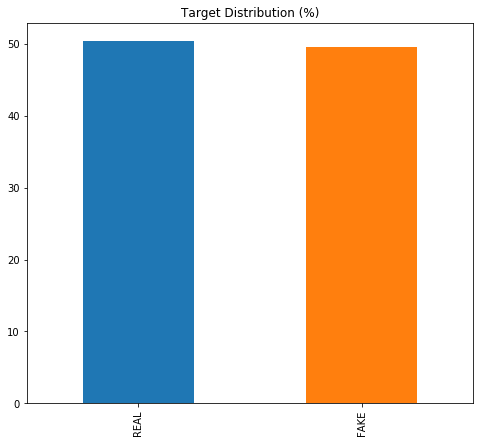

In [8]:
hp.target_distribution(train)

The distribution is perfect, therefore no resampling is needed.

In [9]:
train["concat"] = train["title"] + train["text"]
test["concat"] = test["title"] + test["text"]
train.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,id,title,text,label,concat
4541,10536,Statistical Propaganda: How many Syrians has U...,"October 31, 2016 - Fort Russ - Aleksandr Khro...",FAKE,Statistical Propaganda: How many Syrians has U...
2490,8274,'Russia has no intention of attacking anyone -...,"October 28, 2016 112 While the Western press c...",FAKE,'Russia has no intention of attacking anyone -...
4928,3504,"Trump, Clinton trade blows on terror and guns ...",While investigators try to piece together what...,REAL,"Trump, Clinton trade blows on terror and guns ..."
5627,1844,Clinton clearing primary field for potential 2...,Hillary Clinton appears to have scared away mu...,REAL,Clinton clearing primary field for potential 2...
757,2706,What Brian Williams’s Chopper Whopper Says Abo...,Embarrassing and infuriating: the NBC anchor’s...,REAL,What Brian Williams’s Chopper Whopper Says Abo...


## Tokenizing data
We convert the different articles to a matrix of token counts

In [10]:
count_vect = CountVectorizer()
base_train = count_vect.fit_transform(train["concat"])
print(base_train.shape)

(5068, 65231)


## Normalized TF/TF-IDF Representation

Now we transform the matrix of token counts to a normalized tf or tf-idf representation, where tf represents term frequency and tf-idf represents the frequency times the inverse document frequency, that way the importance/scale of certain repeated tokens throughout the text is reduced.

In [11]:
tfidf_transformer = TfidfTransformer()
base_train = tfidf_transformer.fit_transform(base_train)
print(base_train.shape)

(5068, 65231)


### 2 Component PCA on TF-IDF Representation
Now we will reduce dimensionality on the TF-IDF Representation to 2 components to see how they differ.

In [12]:
pcaed = TruncatedSVD(n_components=2).fit_transform(base_train)
pcaed = pd.concat([pd.DataFrame(pcaed).reset_index(drop=True), train["label"].reset_index(drop=True)], axis=1)
pcaed.head()

,0,1,label
0,0.528385,-0.222576,FAKE
1,0.676899,-0.194307,FAKE
2,0.583683,0.113029,REAL
3,0.482949,0.106593,REAL
4,0.541126,-0.059407,REAL


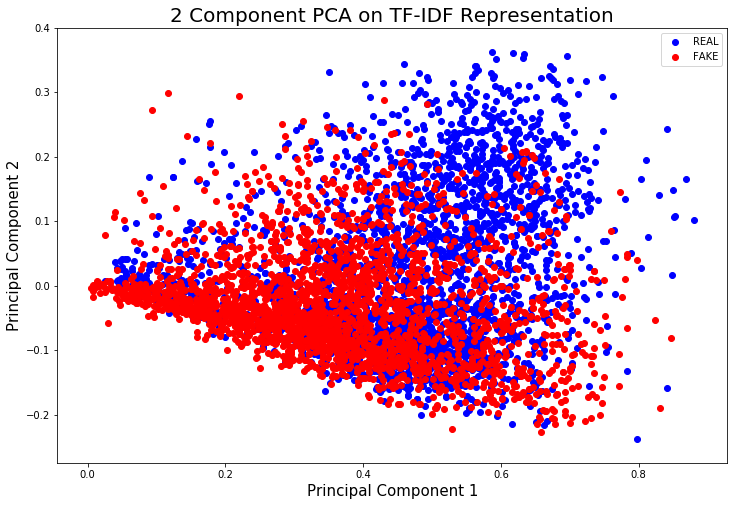

In [13]:
pctrue=pcaed[pcaed["label"]=="REAL"]
pcfake=pcaed[pcaed["label"]=="FAKE"]
plt.figure(figsize = (12,8))
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 Component PCA on TF-IDF Representation', fontsize = 20)
plt.scatter(pctrue[0], pctrue[1], color="blue")
plt.scatter(pcfake[0], pcfake[1], color="red")
plt.legend(["REAL", "FAKE"])

We can see that they are very similar and that there is no clear distinction between the two.

## Baseline

In order to test the performance of our feature engineering steps, we will create several initial baseline models, that way we will see how our efforts increase the models predictive power.

### Train Function
Here we define the train function which will be used with the different models, it performs a cross validation score on 80% of the training data and a final validation on the remaining 20%.

In [14]:
basepipe = Pipeline([
    ('vect', TfidfVectorizer(stop_words="english", ngram_range=(1,2), sublinear_tf=True))
])
    

models = [
    {"name": "naive", "model": MultinomialNB()},
    {"name": "logistic_regression", "model": LogisticRegression(solver="lbfgs", max_iter=KEYS["ITERATIONS"], random_state=KEYS["SEED"])},
    {"name": "svm", "model": SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=KEYS["SEED"])},
    {"name": "pac", "model":  PassiveAggressiveClassifier(max_iter=1000, random_state=KEYS["SEED"], tol=1e-3)},
]

all_scores = hp.pipeline(train[["concat", "label"]], models, basepipe, note="Base models")

,Model,CV Score,Time,Steps,Note
0,naive,0.778 +/- 0.002,23.542809,vect,Base models
1,logistic_regression,0.914 +/- 0.004,32.320865,vect,Base models
2,svm,0.915 +/- 0.006,19.494441,vect,Base models
3,pac,0.938 +/- 0.008,19.385135,vect,Base models


We can see that the Passive Aggressive classifier was the best performing one during our baseline.

## Feature Engineering

### Stemming
Here we stem the news text with two different stemmers Porter and Snowball. Overall, we perform the following transformations:

- Stemming of the words

- Removing punctuation, stop words and other characters

- Convert to Lower case and split string into words (tokenization)

In [15]:
def stemmer(df, stem = "snow"):
    if stem == "port":
        stemmer = PorterStemmer()
    else:
        stemmer = SnowballStemmer(language='english')
    df = df.apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split()]).lower())
    return df

### Original

In [16]:
train.iloc[3:4]["concat"]

5627    Clinton clearing primary field for potential 2...
Name: concat, dtype: object

### Stemmed

In [17]:
stemmer(train["concat"].iloc[3:4])

5627    clinton clear primari field for potenti run co...
Name: concat, dtype: object

Stemming is closely related to lemmatization. The difference is that a stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech. However, stemmers are typically easier to implement and run faster, and the reduced accuracy may not matter for some applications.

## Lemmatizing and POS Tagging with Spacy

Using Spacy we will do the following transformations:

- Lemmatization of the words

- POS Tagging of the words

- Removing punctuation, stop words and other characters

- Convert to Lower case and split string into words (tokenization)

- We remove words with a frequency of less than 0.01% or with more than 0.99%

Here is a sample of the lemmatization and tagging:

In [18]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])
doc = nlp(train['concat'][3])
print(doc.text[:50])
print('----------------------------------------------------')
for token in doc[:5]:
    print(f'Token: {token.text}, Lemma: {token.lemma_}, POS: {token.pos_}')

Bernie supporters on Twitter erupt in anger agains
----------------------------------------------------
Token: Bernie, Lemma: Bernie, POS: PROPN
Token: supporters, Lemma: supporter, POS: NOUN
Token: on, Lemma: on, POS: ADP
Token: Twitter, Lemma: Twitter, POS: PROPN
Token: erupt, Lemma: erupt, POS: NOUN


### Defining our own Tokenizer

We define our own tokenizer, which lemmatizes, lowercases and adds POS tagging. We also try removing stop words, punctuations and digits with a second tokenizer.

In [19]:
def tokenizer(text):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])
    return [token.lemma_.lower().strip() + token.pos_ for token in nlp(text)]

In [20]:
def strict_tokenizer(text):
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])
    return [token.lemma_.lower().strip() + token.pos_ for token in nlp(text)
        if 
            not token.is_stop and not nlp.vocab[token.lemma_].is_stop
            and not token.is_punct
            and not token.is_digit
    ]

## Pipelines
Now we define 2 different pipelines that will be tested, one with Stemming and another one with Lemmatization.

### Pipeline 1: Snowball Stemmer

In [21]:
snow_pipe = Pipeline([
    ('snow_stem', FunctionTransformer(stemmer, validate=False)),
    ('vect', TfidfVectorizer(stop_words="english", ngram_range=(1,2), sublinear_tf=True)),
])

### Pipeline 2: Porter Stemmer

In [22]:
port_pipe = Pipeline([
    ('port_stem', FunctionTransformer(stemmer, kw_args={"stem": "port"}, validate=False)),
    ('vect', TfidfVectorizer(stop_words="english", ngram_range=(1,2), sublinear_tf=True)),
])

### Pipeline 3: Lemmatizer with POS Tagging

In [23]:
lemm_pipe = Pipeline([
    ('lemma_vect', TfidfVectorizer(analyzer = 'word', max_df=0.99, min_df=0.01, ngram_range=(1,2), tokenizer=tokenizer))
])

### Pipeline 4: Strict Lemmatizer with POS Tagging

In [24]:
strict_lemm_pipe = Pipeline([
    ('strict_lemma_vect', TfidfVectorizer(analyzer = 'word', max_df=0.99, min_df=0.01, ngram_range=(1,2), tokenizer=strict_tokenizer))
])

And these are the models we will test with the different pipelines, based on the results obtained from our baselines

In [25]:
models = [
    {"name": "logistic_regression", "model": LogisticRegression(solver="lbfgs", max_iter=KEYS["ITERATIONS"], random_state=KEYS["SEED"])},
    {"name": "pac", "model":  PassiveAggressiveClassifier(max_iter=KEYS["ITERATIONS"], random_state=KEYS["SEED"], tol=1e-3)},
]

Testing all pipelines consecutively.

In [26]:
all_scores = hp.pipeline(train[["concat", "label"]], models, snow_pipe, all_scores=all_scores, quiet = True)
all_scores = hp.pipeline(train[["concat", "label"]], models, port_pipe, all_scores=all_scores, quiet = True)
all_scores = hp.pipeline(train[["concat", "label"]], models, lemm_pipe, all_scores=all_scores, quiet = True)
all_scores = hp.pipeline(train[["concat", "label"]], models, strict_lemm_pipe, all_scores=all_scores)

,Model,CV Score,Time,Steps,Note
0,naive,0.778 +/- 0.002,23.542809,vect,Base models
1,logistic_regression,0.914 +/- 0.004,32.320865,vect,Base models
2,svm,0.915 +/- 0.006,19.494441,vect,Base models
3,pac,0.938 +/- 0.008,19.385135,vect,Base models
4,logistic_regression,0.910 +/- 0.005,109.424714,"snow_stem, vect",
5,pac,0.934 +/- 0.004,98.969398,"snow_stem, vect",
6,logistic_regression,0.911 +/- 0.008,156.788115,"port_stem, vect",
7,pac,0.934 +/- 0.004,149.357601,"port_stem, vect",
8,logistic_regression,0.927 +/- 0.006,1389.405896,lemma_vect,
9,pac,0.953 +/- 0.004,1386.145011,lemma_vect,


### Pipeline Performance by Model

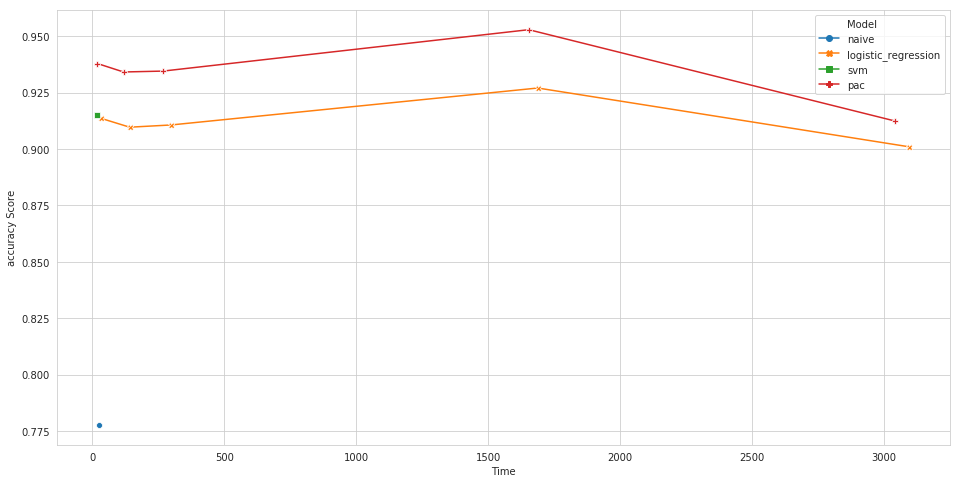

In [27]:
hp.plot_models(all_scores)

### Top Pipelines per Model

Here we show the top pipelines per model.

In [28]:
hp.show_scores(all_scores, top=True)

,CV Score,Time,Steps,Note
Model,,,,
logistic_regression,0.927 +/- 0.006,1389.405896,lemma_vect,
naive,0.778 +/- 0.002,23.542809,vect,Base models
pac,0.953 +/- 0.004,1386.145011,lemma_vect,
svm,0.915 +/- 0.006,19.494441,vect,Base models


## Hyperparameter Tuning

Now that we have the best performing model which is a Passive Agressive Classifier with lemmatization and POS tagging of the concatenated text and title, we will do a 5 fold cross validated randomized grid search over it to get the best parameters for the model.

In [29]:
grid = {
    "pac__C": [1.0, 10.0],
    "pac__tol": [1e-2, 1e-3],
    "pac__max_iter": [500, 1000],
}

final_scores, pipe = hp.cross_val(train[["concat", "label"]], model=clone(hp.top_pipeline(all_scores)), grid=grid)
final_scores

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


array([0.95244672, 0.95284136, 0.95244672, 0.95264404, 0.95284136,
       0.95244672, 0.95284136, 0.95244672])

In [30]:
print(pipe.best_params_)
final_pipe = pipe.best_estimator_

{'pac__tol': 0.001, 'pac__max_iter': 500, 'pac__C': 1.0}


## Explaining the model
Here we see the associated weights to the different tokens and wether they are positive or negative with regards to classifying a news as REAL.

It seems like proper punctuation ('s in the end of words, use of commas, etc) really help the model to see if it is a real or fake news, also having many exclamation signs does the inverse.

In [31]:
eli5.show_weights(final_pipe, top=30, target_names=train.label)

Weight?,Feature
+6.582,SPACE “PROPN
+5.347,'sPART
+3.557,--PUNCT
+3.100,—PUNCT
+2.948,.PUNCT butCCONJ
+2.898,gopNOUN
+2.753,butCCONJ
+2.615,",PUNCT SPACE"
+2.569,marriageNOUN
+2.444,attackNOUN


### Explained prediction on one news article
Usign the same library we will attempt to understand how a specific news item from the test set is predicted.

In [32]:
test.concat.iloc[2]

'Dog Waited Faithfully For Over A Month After His Owners Left Him BehindThere have been horror stories of families leaving behind their pets when they move out, but usually they’re left inside the house where real estate agents can find them. For Boo the dog, he... '

In [33]:
eli5.show_prediction(final_pipe.named_steps['pac'], test.concat.iloc[2], vec = final_pipe.named_steps['lemma_vect'], top=30, target_names=train.label)

From the weights of the different positive and negative tokens the news has we can see how it would predict the article as Fake.

## Predictions and Results on Test Set

Now with our final pipeline we perform preditions on the entire test set.

To review the performance of the model, accuracy is not enough, therefore we plot a confusion matrix and print a classification report.

### Accuracy

In [34]:
predictions = final_pipe.predict(test["concat"])
metric_scorer(test["label"], predictions)

0.9621152328334649

### Classification Report

In [35]:
print(classification_report(test["label"], predictions))

              precision    recall  f1-score   support

        FAKE       0.97      0.96      0.96       651
        REAL       0.96      0.96      0.96       616

   micro avg       0.96      0.96      0.96      1267
   macro avg       0.96      0.96      0.96      1267
weighted avg       0.96      0.96      0.96      1267



### Confusion Matrix

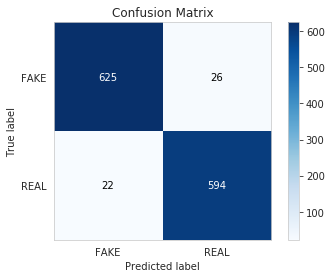

In [36]:
plot_confusion_matrix(test["label"], predictions)

# Conclusions

The classification report obtained from our final model on a 20% holdout of the data shows its accuracy, precision (how often the predictions are correct) and the recall (how many of the total observations in the set are correctly classified), also its f1-score (harmonic average of both). The weighted average for all of them stands at 96% which means that it can classify which articles are fake with great efficacy.

This information is extremely useful to multiple actors, including social networks and end consumers since it can help them differentiate between real and fake stories, which often lead to skewed views of current world events.